# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: I'm going to use a pretrained model (Resnet50) in SegmakerStudio to train my own data, going to fine tune the modek with some hypoparameters, and eventually going to check Debugging profiling and deploy my model.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()

## Dataset
TODO: I'm using the dog breed classification dataset .

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-09-21 09:40:12--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.80
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

100%[====================================>] 1,132,023,110 18.4MB/s   in 57s    

2022-09-21 09:41:09 (19.1 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#TODO: Declare your HP ranges, metrics etc.

# first uploading my data to S3 bucket
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "dogImagesDataset"

role = sagemaker.get_execution_role()

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))



input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-211802338925/dogImagesDataset


In [4]:
# Second my HP ranges
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [5]:
#TODO: Create estimators for your HPs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo_1.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=8,
    max_parallel_jobs=4,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs }, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................................................................................................

In [26]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-09-21 14:45:54 Starting - Preparing the instances for training
2022-09-21 14:45:54 Downloading - Downloading input data
2022-09-21 14:45:54 Training - Training image download completed. Training in progress.
2022-09-21 14:45:54 Uploading - Uploading generated training model
2022-09-21 14:45:54 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'lr': '0.0002075107667149392',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-09-21-10-14-52-313"',
 'sagemaker_program': '"hpo_1.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-211802338925/pytorch-training-2022-09-21-10-14-52-313/source/sourcedir.tar.gz"'}

In [37]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],}
print(best_hyperparameters)

{'batch_size': 128, 'lr': '0.0002075107667149392'}


## Model Profiling and Debugging
TODO: i'm Using my best hyperparameters, to create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [45]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig,CollectionConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [ ]:
# TODO: Create and fit an estimator
best_hyperparameters={'batch_size': 128, 'lr': 0.0002075107667149392}
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    role=role,
    framework_version="1.6",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({'train' : inputs },wait=True)

2022-09-22 23:33:56 Starting - Starting the training job...
2022-09-22 23:34:21 Starting - Preparing the instances for trainingOvertraining: InProgress
ProfilerReport: InProgress
......
2022-09-22 23:35:21 Downloading - Downloading input data............
2022-09-22 23:37:22 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-22 23:37:13,084 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-22 23:37:13,086 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-22 23:37:13,097 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-22 23:37:13,104 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-22 23:37:13,607 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
202

In [47]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-09-22-23-33-56-146
Region: us-east-1


In [48]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-09-22 23:54:49.826 ip-172-16-6-148.ec2.internal:15927 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-211802338925/pytorch-training-2022-09-22-23-33-56-146/debug-output


In [49]:
# TODO: Plot a debugging output.
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show();

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


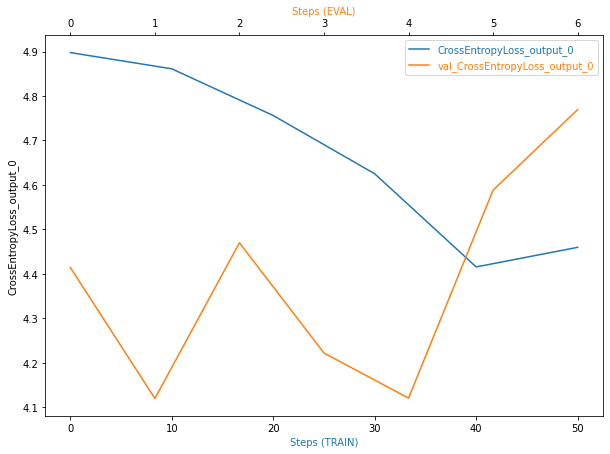

In [52]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
>> Yes, there are different highs and lows for the batch sets. If not

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

>> I think trying out different neural network architecture would be good idea.

In [55]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-211802338925/pytorch-training-2022-09-22-23-33-56-146/rule-output


In [56]:
! aws s3 ls {rule_output_path} --recursive

2022-09-22 23:53:23     364520 pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-09-22 23:53:23     211567 pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-09-22 23:53:19        192 pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-09-22 23:53:19        200 pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-09-22 23:53:19       1996 pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-09-22 23:53:19        127 pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-09-22 23:53:19        199 pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-re

In [57]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-211802338925/pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-211802338925/pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-211802338925/pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json to ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json
download: s3://sagemaker-us-east-1-211802338925/pytorch-training-2022-09-22-23-33-56-146/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-21180

In [59]:
# TODO: Display the profiler output

import os

profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [60]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [61]:
import shutil
shutil.make_archive("./model_repot_profiler", "zip", "ProfilerReport")

'/home/ec2-user/SageMaker/model_repot_profiler.zip'

## Model Deploying

In [21]:
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

role = sagemaker.get_execution_role()
instance_type = "ml.t2.medium"
# instance_type = "local"
model_data_artifacts = "s3://sagemaker-us-east-1-211802338925/pytorch-training-220922-2146-008-cbc302d3/output/model.tar.gz"

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "end_point.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = instance_type)

------------!

Image tested:


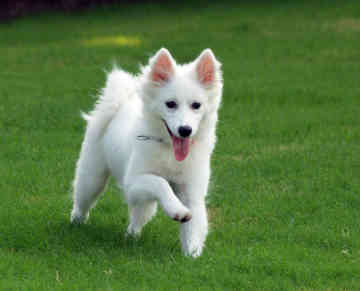

pridection is : [91]


In [22]:
## TODO: Run an prediction on the endpoint
from PIL import Image
import io
import os
import numpy as np

img_path = "my_tsting_img/American_eskimo_dog_00451-Copy1.jpg" 

with open(img_path , "rb") as f:
    payload = f.read()
    print("Image tested:")
    display(Image.open(io.BytesIO(payload)))
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    predicted_dog_breed = np.argmax(response,1) + 1
    print(f"pridection is : {predicted_dog_breed}")

In [23]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

In [1]:
!tar chvfz notebook.tar.gz *

dogImages/
dogImages/valid/
dogImages/valid/033.Bouvier_des_flandres/
dogImages/valid/033.Bouvier_des_flandres/Bouvier_des_flandres_02356.jpg
dogImages/valid/033.Bouvier_des_flandres/Bouvier_des_flandres_02358.jpg
dogImages/valid/033.Bouvier_des_flandres/Bouvier_des_flandres_02325.jpg
dogImages/valid/033.Bouvier_des_flandres/Bouvier_des_flandres_02359.jpg
dogImages/valid/033.Bouvier_des_flandres/Bouvier_des_flandres_02329.jpg
dogImages/valid/033.Bouvier_des_flandres/Bouvier_des_flandres_02322.jpg
dogImages/valid/077.Gordon_setter/
dogImages/valid/077.Gordon_setter/Gordon_setter_05281.jpg
dogImages/valid/077.Gordon_setter/Gordon_setter_05282.jpg
dogImages/valid/077.Gordon_setter/Gordon_setter_05284.jpg
dogImages/valid/077.Gordon_setter/Gordon_setter_05302.jpg
dogImages/valid/077.Gordon_setter/Gordon_setter_05304.jpg
dogImages/valid/077.Gordon_setter/Gordon_setter_05271.jpg
dogImages/valid/120.Pharaoh_hound/
dogImages/valid/120.Pharaoh_hound/Pharaoh_hound_07744.jpg
dogImages/valid/120.Ph

In [24]:
!zip -r ProfilerReport.zip ProfilerReport

  adding: ProfilerReport/ (stored 0%)
  adding: ProfilerReport/profiler-output/ (stored 0%)
  adding: ProfilerReport/profiler-output/profiler-report.html (deflated 83%)
  adding: ProfilerReport/profiler-output/profiler-reports/ (stored 0%)
  adding: ProfilerReport/profiler-output/profiler-reports/Dataloader.json (deflated 60%)
  adding: ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json (deflated 49%)
  adding: ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json (deflated 17%)
  adding: ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json (deflated 31%)
  adding: ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json (deflated 51%)
  adding: ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json (deflated 22%)
  adding: ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json (deflated 18%)
  adding: ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json (deflated 31